In [33]:
import numpy as np
import pandas as pd

In [34]:
models = [
#     "GAE",
#     "VGAE",
#     "ARGA",
#     "ARVGA",
#     "AGE",
#     "DGI",
#     "MVGRL",
    "GRACE",
#     "GGD"
]

In [35]:
datasets = [
    "cora",
    "citeseer",
    "wiki",
    "pubmed",
    "amazon-photo",
    "amazon-computers"
]

In [36]:
import pickle as pkl

import networkx as nx
import numpy as np
import scipy.sparse as sp
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score
import sklearn.preprocessing as preprocess
import sys
def load_data(dataset_str): # {'pubmed', 'citeseer', 'cora'}
    """Load data."""

    if dataset_str == 'wiki':
        adj, features, label = load_wiki()
        return adj, features, label, 0, 0, 0

    elif dataset_str in ["cora", "citeseer", "pubmed"]:

        names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
        objects = []
        for i in range(len(names)):
            with open("/data/liuyue/New/AGE/data/ind.{}.{}".format(dataset_str, names[i]), 'rb') as f:
                if sys.version_info > (3, 0):
                    objects.append(pkl.load(f, encoding='latin1'))
                else:
                    objects.append(pkl.load(f))

        x, y, tx, ty, allx, ally, graph = tuple(objects)
        test_idx_reorder = parse_index_file("/data/liuyue/New/AGE/data/ind.{}.test.index".format(dataset_str))
        test_idx_range = np.sort(test_idx_reorder)

        if dataset_str == 'citeseer':
            # Fix citeseer dataset (there are some isolated nodes in the graph)
            # Find isolated nodes, add them as zero-vecs into the right position
            test_idx_range_full = range(min(test_idx_reorder), max(test_idx_reorder)+1)
            tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
            tx_extended[test_idx_range-min(test_idx_range), :] = tx
            tx = tx_extended
            ty_extended = np.zeros((len(test_idx_range_full), y.shape[1]))
            ty_extended[test_idx_range-min(test_idx_range), :] = ty
            ty = ty_extended

        features = sp.vstack((allx, tx)).tolil()
        features[test_idx_reorder, :] = features[test_idx_range, :]
        adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))

        labels = np.vstack((ally, ty))
        labels[test_idx_reorder, :] = labels[test_idx_range, :]

        idx_test = test_idx_range.tolist()
        idx_train = range(len(y))
        idx_val = range(len(y), len(y)+500)


        if labels.ndim > 1:
            if labels.shape[1] == 1:
                labels = labels.view(-1)
            else:
                labels = labels.argmax(1)

    elif dataset_str in ["amazon-photo", "amazon-computers"]:
        map2names = {
            "amazon-photo": "/data/liuyue/New/SBM/mySBM/data/amazon_electronics_photo.npz",
            "amazon-computers": "/data/liuyue/New/SBM/mySBM/data/amazon_electronics_computers.npz",
        }

        data = np.load(map2names[dataset_str])
        # print(list(data.keys()))
        adj_data, adj_indices, adj_indptr, adj_shape = data["adj_data"], data["adj_indices"], data["adj_indptr"], data["adj_shape"]
        attr_data, attr_indices, attr_indptr, attr_shape = data["attr_data"], data["attr_indices"], data["attr_indptr"], data["attr_shape"]
        labels = data["labels"]

        adj = sp.csr_matrix((adj_data, adj_indices, adj_indptr), shape=adj_shape).tocoo()
        features = sp.csr_matrix((attr_data, attr_indices, attr_indptr), shape=attr_shape).tocoo()

        if labels.ndim > 1:
            if labels.shape[1] == 1:
                labels = labels.reshape(-1)
            else:
                labels = labels.argmax(1)

        return adj, features, labels, 0, 0, 0

    return adj, features, labels, idx_train, idx_val, idx_test

def load_wiki():
    f = open('/data/liuyue/New/AGE/data/graph.txt','r')
    adj, xind, yind = [], [], []
    for line in f.readlines():
        line = line.split()
        
        xind.append(int(line[0]))
        yind.append(int(line[1]))
        adj.append([int(line[0]), int(line[1])])
    f.close()
    ##print(len(adj))

    f = open('/data/liuyue/New/AGE/data/group.txt','r')
    label = []
    for line in f.readlines():
        line = line.split()
        label.append(int(line[1]))
    f.close()

    f = open('/data/liuyue/New/AGE/data/tfidf.txt','r')
    fea_idx = []
    fea = []
    adj = np.array(adj)
    adj = np.vstack((adj, adj[:,[1,0]]))
    adj = np.unique(adj, axis=0)
    
    labelset = np.unique(label)
    labeldict = dict(zip(labelset, range(len(labelset))))
    label = np.array([labeldict[x] for x in label])
    adj = sp.csr_matrix((np.ones(len(adj)), (adj[:,0], adj[:,1])), shape=(len(label), len(label)))

    for line in f.readlines():
        line = line.split()
        fea_idx.append([int(line[0]), int(line[1])])
        fea.append(float(line[2]))
    f.close()

    fea_idx = np.array(fea_idx)
    features = sp.csr_matrix((fea, (fea_idx[:,0], fea_idx[:,1])), shape=(len(label), 4973)).toarray()
    scaler = preprocess.MinMaxScaler()
    #features = preprocess.normalize(features, norm='l2')
    features = scaler.fit_transform(features)
    features = torch.FloatTensor(features)

    return adj, features, label
def parse_index_file(filename):
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index
def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)

In [37]:
true_labels = {}
num_edges = {}
for dataset in datasets:
    adj, _, label, _, _, _ = load_data(dataset)
    true_labels[dataset] = label
    num_edges[dataset] = adj.sum()
    print("{}: {} {}".format(dataset, label.shape, num_edges[dataset]))

cora: (2708,) 10556
citeseer: (3327,) 9228
wiki: (2405,) 24357.0
pubmed: (19717,) 88651
amazon-photo: (7650,) 143663.0
amazon-computers: (13752,) 287209.0


In [38]:
def louvain_cluster(adj, labels, random_state=None):
    from community import community_louvain
    import networkx as nx
    from sklearn.metrics import normalized_mutual_info_score as NMI, adjusted_mutual_info_score as AMI

    graph = nx.from_scipy_sparse_matrix(adj)
    partition = community_louvain.best_partition(graph, random_state=random_state)
    preds = list(partition.values())

    return preds

In [39]:
df = pd.DataFrame(data={"models":models}, columns=["models"] + datasets)
df

,models,cora,citeseer,wiki,pubmed,amazon-photo,amazon-computers
0,GRACE,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
df_nmi = df.copy()
df_ami = df.copy()
df_ari = df.copy()
df_edges = df.copy()

In [41]:
from tqdm import tqdm
import numpy as np
def sampling(adj, rate=0.5, random_state=None):
    n = adj.shape[0]
    adj = adj.toarray()
    
    ret = np.zeros((n,n))
    
    for i in range(n):
        row_idx = adj[i].nonzero()[0]
        arr = np.random.RandomState(seed=random_state).choice(row_idx, int(rate*row_idx.shape[0]))
        ret[i][arr] = 1
    
    return sp.coo_matrix(ret)

In [43]:
from sklearn.metrics import normalized_mutual_info_score as NMI, adjusted_mutual_info_score as AMI, adjusted_rand_score as ARI

sampling_rates = 10
df_data = pd.DataFrame(columns=df.columns)
df_nmi = df_data.copy()
df_ami = df_data.copy()
df_ari = df_data.copy()
    


for model_idx, model in enumerate(models):
    for dataset in datasets:
        
        nmi_m, ami_m, ari_m, nclass_m = {}, {}, {}, {}
        for sampling_rate_idx, sampling_rate in enumerate(range(1,sampling_rates+1)):
            nmis, amis, aris, nclasses = [], [], [], []
            
            
            for seed in range(0,1):
#                 print(model, dataset, seed)
        
                data = np.load("Cluster/{}/lo_{}_preds_{}_{:.1f}.npz".format(model, dataset, seed, sampling_rate))
                preds = data["preds"]
                labels = true_labels[dataset]
                
                nmi = NMI(labels, preds)
                ami = AMI(labels, preds)
                ari = ARI(labels, preds)
                
                nmis.append(nmi)
                amis.append(ami)
                aris.append(ari)
                
                nclasses.append(np.unique(preds).shape[0])
            
            nmi_m[sampling_rate] = np.mean(nmis)
            ami_m[sampling_rate] = np.mean(amis)
            ari_m[sampling_rate] = np.mean(aris)
            nclass_m[sampling_rate] = np.mean(nclasses)
            
#             print(aris)
                
        print(ari_m.values())
#         new_line = pd.DataFrame([[sampling_rate_idx]+list(nmi_m.values())], columns=df.columns)
#         df_nmi = pd.concat([df_nmi, newline], axis=0)
        
#         new_line = pd.DataFrame([[sampling_rate_idx]+list(ami_m.values())], columns=df.columns)
#         df_ami = pd.concat([df_ami, newline], axis=0)
        
#         new_line = pd.DataFrame([[sampling_rate_idx]+list(ari_m.values())], columns=df.columns)
#         df_ari = pd.concat([df_ari, newline], axis=0)

dict_values([0.30387535376177155, 0.4513094082435637, 0.47831522247462194, 0.48277954748948687, 0.4970307224025229, 0.4889590376547102, 0.49093518520276075, 0.5017020355310912, 0.4915211227486043, 0.4982615310637586])
dict_values([0.18779099077966951, 0.30236994906459347, 0.28157798997599465, 0.3149259534179646, 0.30930190369846666, 0.31453855257234115, 0.3416366263637759, 0.3531628975240582, 0.2524701400242884, 0.32416751419255846])
dict_values([0.2929226947415984, 0.2659546236440599, 0.2688644907988058, 0.3098223842177467, 0.27561401061768814, 0.27438340139933476, 0.2812997483958856, 0.29640680953428505, 0.3136334086913465, 0.30938778119866367])
dict_values([0.23142653289244317, 0.15135539383294286, 0.15642639111971676, 0.1594310055654778, 0.15740429058440766, 0.14923496165103997, 0.15484966641425502, 0.16057270449974553, 0.15012126150544106, 0.1178753873437515])
dict_values([0.5379703981506033, 0.4574856362817287, 0.533249029634151, 0.5526375200326936, 0.5455618481036998, 0.55197564

In [44]:
from sklearn.metrics import normalized_mutual_info_score as NMI, adjusted_mutual_info_score as AMI, adjusted_rand_score as ARI

sampling_rates = 10
df_data = pd.DataFrame(columns=df.columns)
df_nmi = df_data.copy()
df_ami = df_data.copy()
df_ari = df_data.copy()
    


for model_idx, model in enumerate(models):
    for dataset in datasets:
        
        nmi_m, ami_m, ari_m, nclass_m = {}, {}, {}, {}
        for sampling_rate_idx, sampling_rate in enumerate(range(1,sampling_rates+1)):
            nmis, amis, aris, nclasses = [], [], [], []
            
            
            for seed in range(0,1):
#                 print(model, dataset, seed)
        
                data = np.load("Cluster/{}/lo_{}_preds_{}_{:.1f}.npz".format(model, dataset, seed, sampling_rate))
                preds = data["preds"]
                labels = true_labels[dataset]
                
                nmi = NMI(labels, preds)
                ami = AMI(labels, preds)
                ari = ARI(labels, preds)
                
                nmis.append(nmi)
                amis.append(ami)
                aris.append(ari)
                
                nclasses.append(np.unique(preds).shape[0])
            
            nmi_m[sampling_rate] = np.mean(nmis)
            ami_m[sampling_rate] = np.mean(amis)
            ari_m[sampling_rate] = np.mean(aris)
            nclass_m[sampling_rate] = np.mean(nclasses)
            
#             print(aris)
                
        print(ami_m.values())
#         new_line = pd.DataFrame([[sampling_rate_idx]+list(nmi_m.values())], columns=df.columns)
#         df_nmi = pd.concat([df_nmi, newline], axis=0)
        
#         new_line = pd.DataFrame([[sampling_rate_idx]+list(ami_m.values())], columns=df.columns)
#         df_ami = pd.concat([df_ami, newline], axis=0)
        
#         new_line = pd.DataFrame([[sampling_rate_idx]+list(ari_m.values())], columns=df.columns)
#         df_ari = pd.concat([df_ari, newline], axis=0)

dict_values([0.40541085256434944, 0.5152132906136876, 0.5466600332360004, 0.549339467042091, 0.5560348991097678, 0.556025939053766, 0.5545772225721289, 0.5684709235537129, 0.5517120906662679, 0.5563522043706635])
dict_values([0.20253629640911638, 0.31775901584675115, 0.31651024366412384, 0.3402564287988185, 0.34314276922125214, 0.34121050522989826, 0.3591692561466341, 0.3655925351224538, 0.3099456959799229, 0.34738005291407353])
dict_values([0.46378590038846995, 0.4598279714280574, 0.4609655328251466, 0.44218300955658735, 0.4489658061404931, 0.4444558269287205, 0.4506771111939444, 0.4360137538557777, 0.4682991811438131, 0.46825955349382614])
dict_values([0.2743509756284202, 0.28664646721364145, 0.26599064848099085, 0.2864955194149539, 0.28250772342824626, 0.2707549941388011, 0.2805897227938543, 0.28316252983433776, 0.2701010075153727, 0.24903409402578916])
dict_values([0.6514835932776664, 0.6003468718008032, 0.6494872226479402, 0.6628160444237269, 0.6447165721223715, 0.6603486438301839

In [45]:
from sklearn.metrics import normalized_mutual_info_score as NMI, adjusted_mutual_info_score as AMI, adjusted_rand_score as ARI

sampling_rates = 10
df_data = pd.DataFrame(columns=df.columns)
df_nmi = df_data.copy()
df_ami = df_data.copy()
df_ari = df_data.copy()
    


for model_idx, model in enumerate(models):
    for dataset in datasets:
        
        nmi_m, ami_m, ari_m, nclass_m = {}, {}, {}, {}
        for sampling_rate_idx, sampling_rate in enumerate(range(1,sampling_rates+1)):
            nmis, amis, aris, nclasses = [], [], [], []
            
            
            for seed in range(0,1):
#                 print(model, dataset, seed)
        
                data = np.load("Cluster/{}/lo_{}_preds_{}_{:.1f}.npz".format(model, dataset, seed, sampling_rate))
                preds = data["preds"]
                labels = true_labels[dataset]
                
                nmi = NMI(labels, preds)
                ami = AMI(labels, preds)
                ari = ARI(labels, preds)
                
                nmis.append(nmi)
                amis.append(ami)
                aris.append(ari)
                
                nclasses.append(np.unique(preds).shape[0])
            
            nmi_m[sampling_rate] = np.mean(nmis)
            ami_m[sampling_rate] = np.mean(amis)
            ari_m[sampling_rate] = np.mean(aris)
            nclass_m[sampling_rate] = np.mean(nclasses)
            
#             print(aris)
                
        print(nmi_m.values())
#         new_line = pd.DataFrame([[sampling_rate_idx]+list(nmi_m.values())], columns=df.columns)
#         df_nmi = pd.concat([df_nmi, newline], axis=0)
        
#         new_line = pd.DataFrame([[sampling_rate_idx]+list(ami_m.values())], columns=df.columns)
#         df_ami = pd.concat([df_ami, newline], axis=0)
        
#         new_line = pd.DataFrame([[sampling_rate_idx]+list(ari_m.values())], columns=df.columns)
#         df_ari = pd.concat([df_ari, newline], axis=0)

dict_values([0.40938271354705785, 0.5171386391382093, 0.5485465236262983, 0.5509759049008394, 0.5576435531170044, 0.5578700313476325, 0.5564318128816756, 0.5702606649609442, 0.5533396622209757, 0.55796129134679])
dict_values([0.21531561512107747, 0.3197863094980459, 0.3184216651406522, 0.3423128825206659, 0.3449899342788834, 0.3428458589456055, 0.36077084270863335, 0.36738052383855757, 0.3118789458935435, 0.3492114691382742])
dict_values([0.4703864255162751, 0.46641784187913254, 0.46754112410460263, 0.4489640954500718, 0.45569196453786887, 0.45120571632466483, 0.4573525712635067, 0.4421609722033815, 0.47476154961261297, 0.47472702643523024])
dict_values([0.2750918254157288, 0.28689117916041496, 0.2662238029924078, 0.28671785359848384, 0.28274794049389207, 0.27095808896897045, 0.2808069308566156, 0.2833626268239557, 0.2702854030363697, 0.24925833139680667])
dict_values([0.6521815906223357, 0.6010736693846273, 0.6501315101219081, 0.6634916229998367, 0.645360388372999, 0.6610291597470113,

## DLeiden

In [52]:
from sklearn.metrics import normalized_mutual_info_score as NMI, adjusted_mutual_info_score as AMI, adjusted_rand_score as ARI

sampling_rates = 10
df_data = pd.DataFrame(columns=df.columns)
df_nmi = df_data.copy()
df_ami = df_data.copy()
df_ari = df_data.copy()
    


for model_idx, model in enumerate(models):
    for dataset in datasets:
        
        nmi_m, ami_m, ari_m, nclass_m = {}, {}, {}, {}
        for sampling_rate_idx, sampling_rate in enumerate(range(1,sampling_rates+1)):
            nmis, amis, aris, nclasses = [], [], [], []
            
            
            for seed in range(0,10):
#                 print(model, dataset, seed)
        
                data = np.load("Cluster_leiden/{}/lo_{}_preds_{}_{:.1f}.npz".format(model, dataset, seed, sampling_rate))
                preds = data["preds"]
                labels = true_labels[dataset]
                
                nmi = NMI(labels, preds)
                ami = AMI(labels, preds)
                ari = ARI(labels, preds)
                
                nmis.append(nmi)
                amis.append(ami)
                aris.append(ari)
                
                nclasses.append(np.unique(preds).shape[0])
            
            nmi_m[sampling_rate] = np.mean(nmis)
            ami_m[sampling_rate] = np.mean(amis)
            ari_m[sampling_rate] = np.mean(aris)
            nclass_m[sampling_rate] = np.mean(nclasses)
                
        print(ari_m[10])
#         new_line = pd.DataFrame([[sampling_rate_idx]+list(nmi_m.values())], columns=df.columns)
#         df_nmi = pd.concat([df_nmi, newline], axis=0)
        
#         new_line = pd.DataFrame([[sampling_rate_idx]+list(ami_m.values())], columns=df.columns)
#         df_ami = pd.concat([df_ami, newline], axis=0)
        
#         new_line = pd.DataFrame([[sampling_rate_idx]+list(ari_m.values())], columns=df.columns)
#         df_ari = pd.concat([df_ari, newline], axis=0)

0.47253362112562103
0.3526817171131788
0.3103355545322871
0.14737290935941208
0.5889593265500352
0.30750723578339745


## No Louvain on Link adj

In [119]:
import scipy.sparse as sp
from sklearn.metrics import normalized_mutual_info_score as NMI, adjusted_mutual_info_score as AMI, adjusted_rand_score as ARI
import numpy as np
from scipy.sparse.csgraph import connected_components

sampling_rates = 10

for model_idx, model in enumerate(models):
    for dataset in datasets:
        
        
        nmi_m, ami_m, ari_m, nclass_m = {}, {}, {}, {}
        for sampling_rate_idx, sampling_rate in enumerate(range(1,sampling_rates+1)):
            nmis, amis, aris, nclasses = [], [], [], []
            for seed in range(10):
                print(model, dataset, sampling_rate_idx, seed)

                labels = true_labels[dataset]

                try:
                    data = np.load("{}/{}_{}.npz".format(model, dataset, seed))
                    adj_data, adj_col, adj_row = data["data"], data["col"], data["row"]

                    adj = sp.coo_matrix((adj_data, (adj_row, adj_col)), shape=(labels.shape[0], labels.shape[0]))
                    
                    adj_s = sampling(adj, rate=sampling_rate, random_state=seed).tocsr()
                    
                    n_components, preds = connected_components(csgraph=adj_s, directed=False)

                    nmi = NMI(labels, preds)
                    ami = AMI(labels, preds)
                    ari = ARI(labels, preds)
                    nclass = n_components

                    nmis.append(nmi)
                    amis.append(ami)
                    aris.append(ari)
                    nclasses.append(nclass)
                except Exception as e:
                    print(e.__class__, e)

            try:
                nmi_m[sampling_rate] = np.mean(nmis)
                ami_m[sampling_rate] = np.mean(amis)
                ari_m[sampling_rate] = np.mean(aris)
                nclass_m[sampling_rate] = np.mean(nclasses)


            except Exception as e:
                pass
        
        
        with open("nolouvain.txt", "a+") as f:
            f.write("{}\n".format(dataset))
            f.write("{}\n".format(nmi_m.values()))
            f.write("{}\n".format(ami_m.values()))
            f.write("{}\n".format(ari_m.values()))
            f.write("{}\n".format(nclass_m.values()))
            f.write("\n\n")

            

GRACE cora 0 0
GRACE cora 0 1
GRACE cora 0 2
GRACE cora 0 3
GRACE cora 0 4
GRACE cora 0 5
GRACE cora 0 6
GRACE cora 0 7
GRACE cora 0 8
GRACE cora 0 9
GRACE cora 1 0
GRACE cora 1 1
GRACE cora 1 2
GRACE cora 1 3
GRACE cora 1 4
GRACE cora 1 5
GRACE cora 1 6
GRACE cora 1 7
GRACE cora 1 8
GRACE cora 1 9
GRACE cora 2 0
GRACE cora 2 1
GRACE cora 2 2
GRACE cora 2 3
GRACE cora 2 4
GRACE cora 2 5
GRACE cora 2 6
GRACE cora 2 7
GRACE cora 2 8
GRACE cora 2 9
GRACE cora 3 0
GRACE cora 3 1
GRACE cora 3 2
GRACE cora 3 3
GRACE cora 3 4
GRACE cora 3 5
GRACE cora 3 6
GRACE cora 3 7
GRACE cora 3 8
GRACE cora 3 9
GRACE cora 4 0
GRACE cora 4 1
GRACE cora 4 2
GRACE cora 4 3
GRACE cora 4 4
GRACE cora 4 5
GRACE cora 4 6
GRACE cora 4 7
GRACE cora 4 8
GRACE cora 4 9
GRACE cora 5 0
GRACE cora 5 1
GRACE cora 5 2
GRACE cora 5 3
GRACE cora 5 4
GRACE cora 5 5
GRACE cora 5 6
GRACE cora 5 7
GRACE cora 5 8
GRACE cora 5 9
GRACE cora 6 0
GRACE cora 6 1
GRACE cora 6 2
GRACE cora 6 3
GRACE cora 6 4
GRACE cora 6 5
GRACE cora

KeyboardInterrupt: 

## Check Best AGE Model on Cora, Citeseer, Pubmed, Wiki

In [9]:
plot_models = ["AGE"]
plot_datasets = ["cora", "citeseer", "wiki", "pubmed"]

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 50.68it/s]


2150119 203765.0
0.4957228394336281 0.4943623188089889 0.4428438347598452


100%|████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 58.58it/s]


1090711 102589.0
0.39779864530780656 0.3409344839433952 0.39156743765444957


100%|████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 95.59it/s]


624176 58655.0
0.5186176766785248 0.41935774946070825 0.3496919413942583


100%|████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.13it/s]


47827648 4545749.0
0.25070567024077955 0.16189742227511186 0.24438857179601545


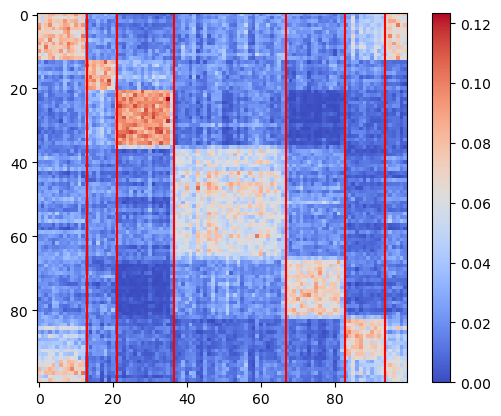

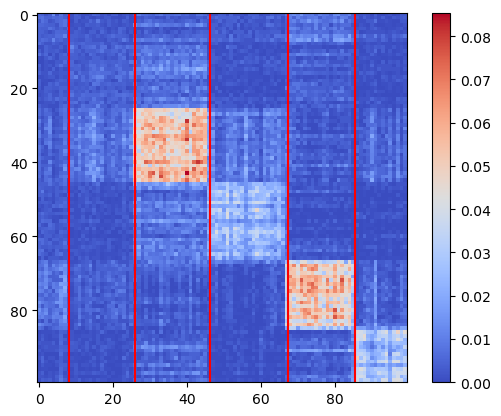

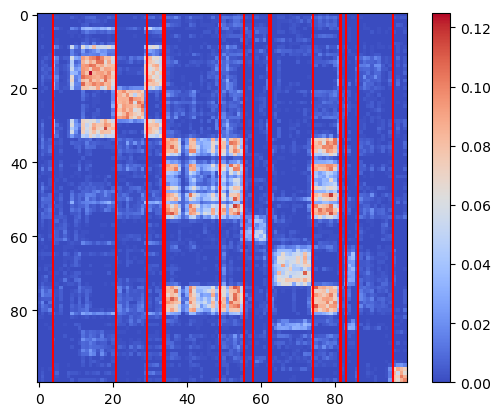

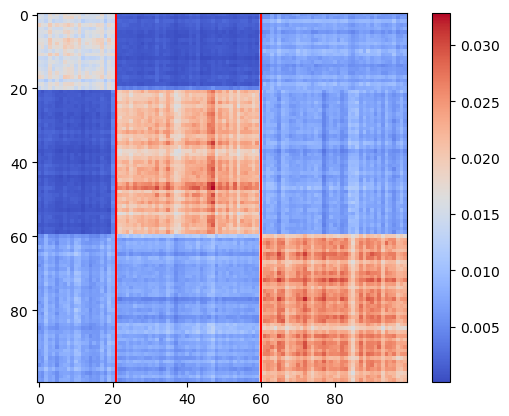

In [12]:
import numpy as np
import scipy.sparse as sp
from vis import *
from sklearn.metrics import normalized_mutual_info_score as NMI, adjusted_mutual_info_score as AMI, adjusted_rand_score as ARI

for model in plot_models:
    for dataset in plot_datasets:
        seed = 0
        
        labels = true_labels[dataset]
        m = num_edges[dataset]
        
        data = np.load("{}/{}_{}.npz".format(model, dataset, seed))
        adj_data, adj_row, adj_col = data["data"], data["row"], data["col"]
        
        adj = sp.coo_matrix((adj_data, (adj_row, adj_col)), shape=(labels.shape[0], labels.shape[0]))
        
        adj_s = sampling(adj, 0.1)
        plot_superadj(adj_s, K=100, sparse=True, labels=labels, dataset="link_s_{}".format(dataset), vline=True)
        
        print(adj.sum(), adj_s.sum())
        
#         preds = louvain_cluster(adj, labels, random_state=seed)
#         nmi = NMI(labels, preds)
#         ami = AMI(labels, preds)
#         ari = ARI(labels, preds)
#         print(nmi, ami, ari)
        
        preds = louvain_cluster(adj_s, labels, random_state=seed)
        nmi = NMI(labels, preds)
        ami = AMI(labels, preds)
        ari = ARI(labels, preds)
        print(nmi, ami, ari)
        
#         break
        
#         print(adj.shape[0], adj.sum())
        
#         plot_superadj(adj, K=100, sparse=True, labels=labels, dataset="link_{}".format(dataset), vline=True)

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 56.91it/s]


847456 79524.0
0.4426569343305898 0.4376188706591063 0.3203139545402435


100%|████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 51.06it/s]


724183 67643.0
0.361669392359769 0.36010074520513563 0.36053614541198215


100%|████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 77.13it/s]


475790 44420.0
0.42406225562709304 0.3863201704650941 0.24897303486487807


100%|████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.37it/s]


23580665 2237241.0
0.24266275922763686 0.24203949433923289 0.1649893513518012


100%|████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.83it/s]


3649516 344494.0
0.6886486278878241 0.6866707922264335 0.6066305451511202


100%|████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.76it/s]


10039323 950580.0
0.5962087915071281 0.595245579824535 0.41865650953116385


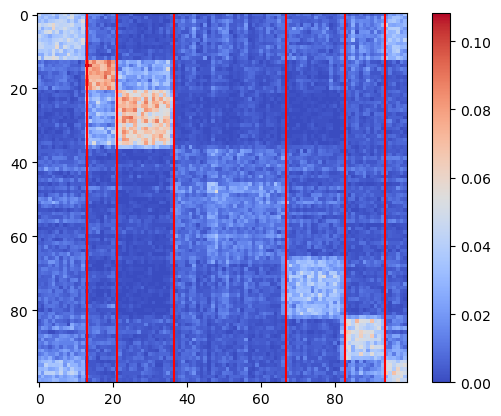

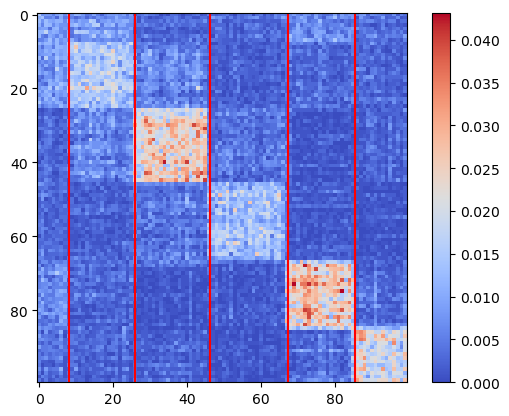

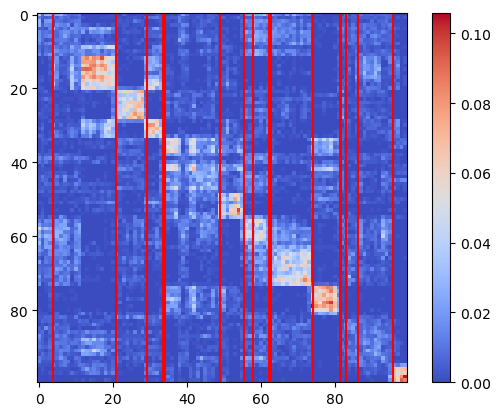

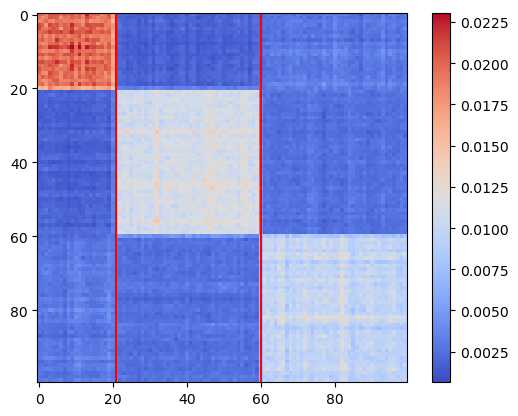

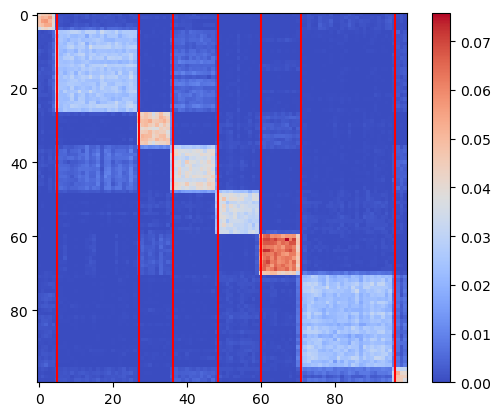

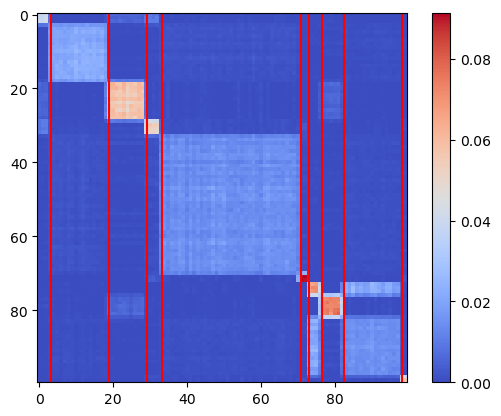

In [58]:
plot_models = ["GRACE"]
plot_datasets = ["cora", "citeseer", "wiki", "pubmed", "amazon-photo", "amazon-computers"]
for model in plot_models:
    for dataset in plot_datasets:
        seed = 0
        
        labels = true_labels[dataset]
        
        data = np.load("{}/{}_{}.npz".format(model, dataset, seed))
        adj_data, adj_row, adj_col = data["data"], data["row"], data["col"]
        
        adj = sp.coo_matrix((adj_data, (adj_row, adj_col)), shape=(labels.shape[0], labels.shape[0]))
        
        adj_s = sampling(adj, 0.1)
        plot_superadj(adj_s, K=100, sparse=True, labels=labels, dataset="link_s_{}".format(dataset), vline=True)
        
        print(adj.sum(), adj_s.sum())
        
#         preds = louvain_cluster(adj, labels, random_state=seed)
#         nmi = NMI(labels, preds)
#         ami = AMI(labels, preds)
#         ari = ARI(labels, preds)
#         print(nmi, ami, ari)
        
        preds = louvain_cluster(adj_s, labels, random_state=seed)
        nmi = NMI(labels, preds)
        ami = AMI(labels, preds)
        ari = ARI(labels, preds)
        print(nmi, ami, ari)
        
#         break
        
#         print(adj.shape[0], adj.sum())
        
#         plot_superadj(adj, K=100, sparse=True, labels=labels, dataset="link_{}".format(dataset), vline=True)

## Check O1 Links

In [9]:
df = pd.DataFrame(data={"models":models}, columns=["models"] + datasets)
df_nmi = df.copy()
df_ami = df.copy()
df_ari = df.copy()
df_edges = df.copy()

In [10]:
import scipy.sparse as sp
from sklearn.metrics import normalized_mutual_info_score as NMI, adjusted_mutual_info_score as AMI, adjusted_rand_score as ARI
import numpy as np

for model_idx, model in enumerate(models):
    for dataset in datasets:
        
        nmis, amis, aris = [], [], []
        edges = []
        
        for seed in range(10):
            print(model, dataset, seed)
            
            labels = true_labels[dataset]
            
            try:
                data = np.load("../link_adj_O1/{}/{}_{}.npz".format(model, dataset, seed))
                adj_data, adj_col, adj_row = data["data"], data["col"], data["row"]
                
                adj = sp.coo_matrix((adj_data, (adj_row, adj_col)), shape=(labels.shape[0], labels.shape[0]))
                
#                 preds = louvain_cluster(adj, labels, random_state=seed)
                
#                 nmi = NMI(labels, preds)
#                 ami = AMI(labels, preds)
#                 ari = ARI(labels, preds)
                
#                 nmis.append(nmi)
#                 amis.append(ami)
#                 aris.append(ari)

                edges.append(adj.sum())
                
            except Exception as e:
                print(e.__class__, e)
        
        try:
#             nmi_m = np.mean(nmis)
#             ami_m = np.mean(amis)
#             ari_m = np.mean(aris)
            edges_m = np.ceil(np.mean(edges))
            
#             df_nmi["{}".format(dataset)][model_idx] = nmi_m
#             df_ami["{}".format(dataset)][model_idx] = ami_m
#             df_ari["{}".format(dataset)][model_idx] = ari_m
            df_edges["{}".format(dataset)][model_idx] = edges_m
        except Exception as e:
            pass
                
            

GAE cora 0
GAE cora 1
GAE cora 2
GAE cora 3
GAE cora 4
GAE cora 5
GAE cora 6
GAE cora 7
GAE cora 8
GAE cora 9
GAE citeseer 0
GAE citeseer 1
GAE citeseer 2
GAE citeseer 3
GAE citeseer 4
GAE citeseer 5
GAE citeseer 6
GAE citeseer 7
GAE citeseer 8
GAE citeseer 9
GAE wiki 0
GAE wiki 1
GAE wiki 2
GAE wiki 3
GAE wiki 4
GAE wiki 5
GAE wiki 6
GAE wiki 7
GAE wiki 8
GAE wiki 9
GAE pubmed 0
GAE pubmed 1
GAE pubmed 2
GAE pubmed 3
GAE pubmed 4
GAE pubmed 5
GAE pubmed 6
GAE pubmed 7
GAE pubmed 8
GAE pubmed 9
GAE amazon-photo 0
GAE amazon-photo 1
GAE amazon-photo 2
GAE amazon-photo 3
GAE amazon-photo 4
GAE amazon-photo 5
GAE amazon-photo 6
GAE amazon-photo 7
GAE amazon-photo 8
GAE amazon-photo 9
GAE amazon-computers 0
GAE amazon-computers 1
GAE amazon-computers 2
GAE amazon-computers 3
GAE amazon-computers 4
GAE amazon-computers 5
GAE amazon-computers 6
GAE amazon-computers 7
GAE amazon-computers 8
GAE amazon-computers 9
VGAE cora 0
VGAE cora 1
VGAE cora 2
VGAE cora 3
VGAE cora 4
VGAE cora 5
VGAE cor

GGD pubmed 1
GGD pubmed 2
GGD pubmed 3
GGD pubmed 4
GGD pubmed 5
GGD pubmed 6
GGD pubmed 7
GGD pubmed 8
GGD pubmed 9
GGD amazon-photo 0
GGD amazon-photo 1
GGD amazon-photo 2
GGD amazon-photo 3
GGD amazon-photo 4
GGD amazon-photo 5
GGD amazon-photo 6
GGD amazon-photo 7
GGD amazon-photo 8
GGD amazon-photo 9
GGD amazon-computers 0
GGD amazon-computers 1
GGD amazon-computers 2
GGD amazon-computers 3
GGD amazon-computers 4
GGD amazon-computers 5
GGD amazon-computers 6
GGD amazon-computers 7
GGD amazon-computers 8
GGD amazon-computers 9


In [11]:
df_edges

,models,cora,citeseer,wiki,pubmed,amazon-photo,amazon-computers
0,GAE,1225579.0,2063880.0,2316665.0,93772406.0,13982827.0,18468586.0
1,VGAE,2373156.0,3553795.0,1064774.0,23061860.0,7900485.0,28076483.0
2,ARGA,1350059.0,2079126.0,897571.0,71124489.0,7158675.0,16868565.0
3,ARVGA,1204631.0,1854349.0,918448.0,104265844.0,9597605.0,52968831.0
4,AGE,518999.0,928942.0,476665.0,56049332.0,4469579.0,62552834.0
5,DGI,634914.0,765035.0,735085.0,39490498.0,5853766.0,13568974.0
6,MVGRL,661773.0,865432.0,584792.0,22514780.0,5575161.0,48636185.0
7,GRACE,619191.0,556164.0,371038.0,21707609.0,4344798.0,10241728.0
8,GGD,635041.0,686264.0,1136144.0,22570835.0,5159239.0,11833528.0


In [12]:
from sklearn.metrics import normalized_mutual_info_score as NMI, adjusted_mutual_info_score as AMI, adjusted_rand_score as ARI

for model_idx, model in enumerate(models):
    for dataset in datasets:
        nmis, amis, aris = [], [], []
        for seed in range(10):
            print(model, dataset, seed)
            
            labels = true_labels[dataset]
            m = num_edges[dataset]
        
            data = np.load("../link_adj_O1/Cluster/{}/lo_{}_preds_{}.npz".format(model, dataset, seed))
            preds = data["preds"]

#             adj = sp.coo_matrix((adj_data, (adj_row, adj_col)), shape=(labels.shape[0], labels.shape[0]))
            
# #             sampling_rate = m / adj.sum()
#             sampling_rate = 0.1
#             adj_s = sampling(adj, sampling_rate)
#             plot_superadj(adj_s, K=100, sparse=True, labels=labels, dataset="link_s_{}".format(dataset), vline=True)

#             print(adj.sum(), adj_s.sum())

#     #         preds = louvain_cluster(adj, labels, random_state=seed)
#     #         nmi = NMI(labels, preds)
#     #         ami = AMI(labels, preds)
#     #         ari = ARI(labels, preds)
#     #         print(nmi, ami, ari)

#             preds = louvain_cluster(adj_s, labels, random_state=seed)
            nmi = NMI(labels, preds)
            ami = AMI(labels, preds)
            ari = ARI(labels, preds)
            
            nmis.append(nmi)
            amis.append(ami)
            aris.append(ari)
            
        nmi_m = np.mean(nmis)
        ami_m = np.mean(amis)
        ari_m = np.mean(aris)
        
        df_nmi["{}".format(dataset)][model_idx] = nmi_m
        df_ami["{}".format(dataset)][model_idx] = ami_m
        df_ari["{}".format(dataset)][model_idx] = ari_m

GAE cora 0
GAE cora 1
GAE cora 2
GAE cora 3
GAE cora 4
GAE cora 5
GAE cora 6
GAE cora 7
GAE cora 8
GAE cora 9
GAE citeseer 0
GAE citeseer 1
GAE citeseer 2
GAE citeseer 3
GAE citeseer 4
GAE citeseer 5
GAE citeseer 6
GAE citeseer 7
GAE citeseer 8
GAE citeseer 9
GAE wiki 0
GAE wiki 1
GAE wiki 2
GAE wiki 3
GAE wiki 4
GAE wiki 5
GAE wiki 6
GAE wiki 7
GAE wiki 8
GAE wiki 9
GAE pubmed 0
GAE pubmed 1
GAE pubmed 2
GAE pubmed 3
GAE pubmed 4
GAE pubmed 5
GAE pubmed 6
GAE pubmed 7
GAE pubmed 8
GAE pubmed 9
GAE amazon-photo 0
GAE amazon-photo 1
GAE amazon-photo 2
GAE amazon-photo 3
GAE amazon-photo 4
GAE amazon-photo 5
GAE amazon-photo 6
GAE amazon-photo 7
GAE amazon-photo 8
GAE amazon-photo 9
GAE amazon-computers 0
GAE amazon-computers 1
GAE amazon-computers 2
GAE amazon-computers 3
GAE amazon-computers 4
GAE amazon-computers 5
GAE amazon-computers 6
GAE amazon-computers 7
GAE amazon-computers 8
GAE amazon-computers 9
VGAE cora 0
VGAE cora 1
VGAE cora 2
VGAE cora 3
VGAE cora 4
VGAE cora 5
VGAE cor

GGD pubmed 4
GGD pubmed 5
GGD pubmed 6
GGD pubmed 7
GGD pubmed 8
GGD pubmed 9
GGD amazon-photo 0
GGD amazon-photo 1
GGD amazon-photo 2
GGD amazon-photo 3
GGD amazon-photo 4
GGD amazon-photo 5
GGD amazon-photo 6
GGD amazon-photo 7
GGD amazon-photo 8
GGD amazon-photo 9
GGD amazon-computers 0
GGD amazon-computers 1
GGD amazon-computers 2
GGD amazon-computers 3
GGD amazon-computers 4
GGD amazon-computers 5
GGD amazon-computers 6
GGD amazon-computers 7
GGD amazon-computers 8
GGD amazon-computers 9


In [13]:
df_nmi

,models,cora,citeseer,wiki,pubmed,amazon-photo,amazon-computers
0,GAE,0.453469,0.311875,0.20907,0.293836,0.29165,0.296007
1,VGAE,0.279374,0.116329,0.177764,0.142297,0.239417,0.217831
2,ARGA,0.298627,0.148899,0.208881,0.244454,0.616468,0.449651
3,ARVGA,0.335511,0.200201,0.275878,0.249685,0.546917,0.356078
4,AGE,0.521445,0.435739,0.5578,0.250042,0.31473,0.19786
5,DGI,0.516621,0.373117,0.439847,0.317265,0.428136,0.312267
6,MVGRL,0.505225,0.401852,0.442628,0.258715,0.348846,0.145805
7,GRACE,0.531338,0.370845,0.435117,0.293228,0.70091,0.579159
8,GGD,0.554246,0.360656,0.412286,0.261035,0.4071,0.309498


In [14]:
df_ari

,models,cora,citeseer,wiki,pubmed,amazon-photo,amazon-computers
0,GAE,0.386348,0.298453,0.104506,0.258557,0.14713,0.083787
1,VGAE,0.223756,0.094607,0.095537,0.12321,0.132337,0.161737
2,ARGA,0.234604,0.135425,0.104706,0.212,0.535496,0.367359
3,ARVGA,0.276179,0.1893,0.167205,0.240181,0.439254,0.31581
4,AGE,0.369485,0.415682,0.354345,0.23202,0.010137,0.127199
5,DGI,0.443947,0.365519,0.230336,0.266022,0.283813,0.168808
6,MVGRL,0.436605,0.393584,0.237965,0.205661,0.226765,0.064116
7,GRACE,0.454988,0.346823,0.282701,0.188703,0.617317,0.414985
8,GGD,0.48736,0.309416,0.202449,0.195205,0.265365,0.199903


## Check O3 links 

In [15]:
df = pd.DataFrame(data={"models":models}, columns=["models"] + datasets)
df_nmi = df.copy()
df_ami = df.copy()
df_ari = df.copy()
df_edges = df.copy()

In [16]:
import scipy.sparse as sp
from sklearn.metrics import normalized_mutual_info_score as NMI, adjusted_mutual_info_score as AMI, adjusted_rand_score as ARI
import numpy as np

for model_idx, model in enumerate(models):
    for dataset in datasets:
        
        nmis, amis, aris = [], [], []
        edges = []
        
        for seed in range(10):
            print(model, dataset, seed)
            
            labels = true_labels[dataset]
            
            try:
                data = np.load("../link_adj_O3/{}/{}_{}.npz".format(model, dataset, seed))
                adj_data, adj_col, adj_row = data["data"], data["col"], data["row"]
                
                adj = sp.coo_matrix((adj_data, (adj_row, adj_col)), shape=(labels.shape[0], labels.shape[0]))
                
#                 preds = louvain_cluster(adj, labels, random_state=seed)
                
#                 nmi = NMI(labels, preds)
#                 ami = AMI(labels, preds)
#                 ari = ARI(labels, preds)
                
#                 nmis.append(nmi)
#                 amis.append(ami)
#                 aris.append(ari)

                edges.append(adj.sum())
                
            except Exception as e:
                print(e.__class__, e)
        
        try:
#             nmi_m = np.mean(nmis)
#             ami_m = np.mean(amis)
#             ari_m = np.mean(aris)
            edges_m = np.ceil(np.mean(edges))
            
#             df_nmi["{}".format(dataset)][model_idx] = nmi_m
#             df_ami["{}".format(dataset)][model_idx] = ami_m
#             df_ari["{}".format(dataset)][model_idx] = ari_m
            df_edges["{}".format(dataset)][model_idx] = edges_m
        except Exception as e:
            pass
                
            

GAE cora 0
GAE cora 1
GAE cora 2
GAE cora 3
GAE cora 4
GAE cora 5
GAE cora 6
GAE cora 7
GAE cora 8
GAE cora 9
GAE citeseer 0
GAE citeseer 1
GAE citeseer 2
GAE citeseer 3
GAE citeseer 4
GAE citeseer 5
GAE citeseer 6
GAE citeseer 7
GAE citeseer 8
GAE citeseer 9
GAE wiki 0
GAE wiki 1
GAE wiki 2
GAE wiki 3
GAE wiki 4
GAE wiki 5
GAE wiki 6
GAE wiki 7
GAE wiki 8
GAE wiki 9
GAE pubmed 0
GAE pubmed 1
GAE pubmed 2
GAE pubmed 3
GAE pubmed 4
GAE pubmed 5
GAE pubmed 6
GAE pubmed 7
GAE pubmed 8
GAE pubmed 9
GAE amazon-photo 0
GAE amazon-photo 1
GAE amazon-photo 2
GAE amazon-photo 3
GAE amazon-photo 4
GAE amazon-photo 5
GAE amazon-photo 6
GAE amazon-photo 7
GAE amazon-photo 8
GAE amazon-photo 9
GAE amazon-computers 0
GAE amazon-computers 1
GAE amazon-computers 2
GAE amazon-computers 3
GAE amazon-computers 4
GAE amazon-computers 5
GAE amazon-computers 6
GAE amazon-computers 7
GAE amazon-computers 8
GAE amazon-computers 9
VGAE cora 0
VGAE cora 1
VGAE cora 2
VGAE cora 3
VGAE cora 4
VGAE cora 5
VGAE cor

GGD pubmed 1
GGD pubmed 2
GGD pubmed 3
GGD pubmed 4
GGD pubmed 5
GGD pubmed 6
GGD pubmed 7
GGD pubmed 8
GGD pubmed 9
GGD amazon-photo 0
GGD amazon-photo 1
GGD amazon-photo 2
GGD amazon-photo 3
GGD amazon-photo 4
GGD amazon-photo 5
GGD amazon-photo 6
GGD amazon-photo 7
GGD amazon-photo 8
GGD amazon-photo 9
GGD amazon-computers 0
GGD amazon-computers 1
GGD amazon-computers 2
GGD amazon-computers 3
GGD amazon-computers 4
GGD amazon-computers 5
GGD amazon-computers 6
GGD amazon-computers 7
GGD amazon-computers 8
GGD amazon-computers 9


In [17]:
df_edges

,models,cora,citeseer,wiki,pubmed,amazon-photo,amazon-computers
0,GAE,3606538.0,1903354.0,916141.0,74108278.0,6152354.0,12471264.0
1,VGAE,3194108.0,5852250.0,3261161.0,212417797.0,41761032.0,129533241.0
2,ARGA,746098.0,3238192.0,608525.0,167698722.0,14318713.0,53777521.0
3,ARVGA,779980.0,3529078.0,592625.0,113849766.0,17274186.0,74467614.0
4,AGE,330008.0,983771.0,479083.0,48883980.0,4242970.0,25855607.0
5,DGI,634488.0,850290.0,637850.0,45431843.0,4559376.0,18851931.0
6,MVGRL,812341.0,1014761.0,607197.0,45837301.0,5841584.0,29896605.0
7,GRACE,1006742.0,939452.0,550617.0,27885741.0,4483051.0,20744443.0
8,GGD,599640.0,762446.0,653690.0,26321239.0,6644442.0,10073920.0


In [21]:
from sklearn.metrics import normalized_mutual_info_score as NMI, adjusted_mutual_info_score as AMI, adjusted_rand_score as ARI

for model_idx, model in enumerate(models):
    for dataset in datasets:
        nmis, amis, aris = [], [], []
        for seed in range(10):
            print(model, dataset, seed)
            
            labels = true_labels[dataset]
            m = num_edges[dataset]
        
            data = np.load("../link_adj_O3/Cluster/{}/lo_{}_preds_{}.npz".format(model, dataset, seed))
            preds = data["preds"]

#             adj = sp.coo_matrix((adj_data, (adj_row, adj_col)), shape=(labels.shape[0], labels.shape[0]))
            
# #             sampling_rate = m / adj.sum()
#             sampling_rate = 0.1
#             adj_s = sampling(adj, sampling_rate)
#             plot_superadj(adj_s, K=100, sparse=True, labels=labels, dataset="link_s_{}".format(dataset), vline=True)

#             print(adj.sum(), adj_s.sum())

#     #         preds = louvain_cluster(adj, labels, random_state=seed)
#     #         nmi = NMI(labels, preds)
#     #         ami = AMI(labels, preds)
#     #         ari = ARI(labels, preds)
#     #         print(nmi, ami, ari)

#             preds = louvain_cluster(adj_s, labels, random_state=seed)
            nmi = NMI(labels, preds)
            ami = AMI(labels, preds)
            ari = ARI(labels, preds)
            
            nmis.append(nmi)
            amis.append(ami)
            aris.append(ari)
            
        nmi_m = np.mean(nmis)
        ami_m = np.mean(amis)
        ari_m = np.mean(aris)
        
        df_nmi["{}".format(dataset)][model_idx] = nmi_m
        df_ami["{}".format(dataset)][model_idx] = ami_m
        df_ari["{}".format(dataset)][model_idx] = ari_m

GAE cora 0
GAE cora 1
GAE cora 2
GAE cora 3
GAE cora 4
GAE cora 5
GAE cora 6
GAE cora 7
GAE cora 8
GAE cora 9
GAE citeseer 0
GAE citeseer 1
GAE citeseer 2
GAE citeseer 3
GAE citeseer 4
GAE citeseer 5
GAE citeseer 6
GAE citeseer 7
GAE citeseer 8
GAE citeseer 9
GAE wiki 0
GAE wiki 1
GAE wiki 2
GAE wiki 3
GAE wiki 4
GAE wiki 5
GAE wiki 6
GAE wiki 7
GAE wiki 8
GAE wiki 9
GAE pubmed 0
GAE pubmed 1
GAE pubmed 2
GAE pubmed 3
GAE pubmed 4
GAE pubmed 5
GAE pubmed 6
GAE pubmed 7
GAE pubmed 8
GAE pubmed 9
GAE amazon-photo 0
GAE amazon-photo 1
GAE amazon-photo 2
GAE amazon-photo 3
GAE amazon-photo 4
GAE amazon-photo 5
GAE amazon-photo 6
GAE amazon-photo 7
GAE amazon-photo 8
GAE amazon-photo 9
GAE amazon-computers 0
GAE amazon-computers 1
GAE amazon-computers 2
GAE amazon-computers 3
GAE amazon-computers 4
GAE amazon-computers 5
GAE amazon-computers 6
GAE amazon-computers 7
GAE amazon-computers 8
GAE amazon-computers 9
VGAE cora 0
VGAE cora 1
VGAE cora 2
VGAE cora 3
VGAE cora 4
VGAE cora 5
VGAE cor

GGD pubmed 8
GGD pubmed 9
GGD amazon-photo 0
GGD amazon-photo 1
GGD amazon-photo 2
GGD amazon-photo 3
GGD amazon-photo 4
GGD amazon-photo 5
GGD amazon-photo 6
GGD amazon-photo 7
GGD amazon-photo 8
GGD amazon-photo 9
GGD amazon-computers 0
GGD amazon-computers 1
GGD amazon-computers 2
GGD amazon-computers 3
GGD amazon-computers 4
GGD amazon-computers 5
GGD amazon-computers 6
GGD amazon-computers 7
GGD amazon-computers 8
GGD amazon-computers 9


In [22]:
df_nmi

,models,cora,citeseer,wiki,pubmed,amazon-photo,amazon-computers
0,GAE,0.236272,0.280091,0.21303,0.278447,0.243609,0.255315
1,VGAE,0.259938,0.112346,0.148757,0.105222,0.175101,0.207655
2,ARGA,0.088748,0.037038,0.125986,0.249356,0.477657,0.353386
3,ARVGA,0.114568,0.048375,0.146376,0.213641,0.441657,0.30495
4,AGE,0.423012,0.38999,0.476278,0.246811,0.168381,0.253044
5,DGI,0.520676,0.386095,0.388156,0.305635,0.37233,0.276813
6,MVGRL,0.534898,0.371462,0.390224,0.2774,0.283311,0.123499
7,GRACE,0.487679,0.363859,0.358072,0.281227,0.699827,0.539673
8,GGD,0.537836,0.336117,0.416317,0.258051,0.401032,0.286352


In [23]:
df_ari

,models,cora,citeseer,wiki,pubmed,amazon-photo,amazon-computers
0,GAE,0.183811,0.267564,0.109429,0.239771,0.133096,0.18603
1,VGAE,0.200574,0.088621,0.084439,0.096561,0.128005,0.201309
2,ARGA,0.054384,0.030856,0.061163,0.255065,0.38941,0.28648
3,ARVGA,0.076104,0.041908,0.070705,0.20427,0.337457,0.257736
4,AGE,0.291391,0.393816,0.29129,0.226483,0.054844,0.18908
5,DGI,0.45604,0.380055,0.23394,0.256313,0.235964,0.186907
6,MVGRL,0.463099,0.358803,0.208719,0.240746,0.199814,0.047918
7,GRACE,0.425345,0.368854,0.198629,0.207532,0.607334,0.396656
8,GGD,0.468841,0.301649,0.250443,0.1982,0.25731,0.158282


## Check link O4

In [26]:
df = pd.DataFrame(data={"models":models}, columns=["models"] + datasets)
df_nmi = df.copy()
df_ami = df.copy()
df_ari = df.copy()
df_edges = df.copy()

In [27]:
import scipy.sparse as sp
from sklearn.metrics import normalized_mutual_info_score as NMI, adjusted_mutual_info_score as AMI, adjusted_rand_score as ARI
import numpy as np

for model_idx, model in enumerate(models):
    for dataset in datasets:
        
        nmis, amis, aris = [], [], []
        edges = []
        
        for seed in range(10):
            print(model, dataset, seed)
            
            labels = true_labels[dataset]
            
            try:
                data = np.load("../link_adj_O4/{}/{}_{}.npz".format(model, dataset, seed))
                adj_data, adj_col, adj_row = data["data"], data["col"], data["row"]
                
                adj = sp.coo_matrix((adj_data, (adj_row, adj_col)), shape=(labels.shape[0], labels.shape[0]))
                
#                 preds = louvain_cluster(adj, labels, random_state=seed)
                
#                 nmi = NMI(labels, preds)
#                 ami = AMI(labels, preds)
#                 ari = ARI(labels, preds)
                
#                 nmis.append(nmi)
#                 amis.append(ami)
#                 aris.append(ari)

                edges.append(adj.sum())
                
            except Exception as e:
                print(e.__class__, e)
        
        try:
#             nmi_m = np.mean(nmis)
#             ami_m = np.mean(amis)
#             ari_m = np.mean(aris)
            edges_m = np.ceil(np.mean(edges))
            
#             df_nmi["{}".format(dataset)][model_idx] = nmi_m
#             df_ami["{}".format(dataset)][model_idx] = ami_m
#             df_ari["{}".format(dataset)][model_idx] = ari_m
            df_edges["{}".format(dataset)][model_idx] = edges_m
        except Exception as e:
            pass
                
            

GAE cora 0
GAE cora 1
GAE cora 2
GAE cora 3
GAE cora 4
GAE cora 5
GAE cora 6
GAE cora 7
GAE cora 8
GAE cora 9
GAE citeseer 0
GAE citeseer 1
GAE citeseer 2
GAE citeseer 3
GAE citeseer 4
GAE citeseer 5
GAE citeseer 6
GAE citeseer 7
GAE citeseer 8
GAE citeseer 9
GAE wiki 0
GAE wiki 1
GAE wiki 2
GAE wiki 3
GAE wiki 4
GAE wiki 5
GAE wiki 6
GAE wiki 7
GAE wiki 8
GAE wiki 9
GAE pubmed 0
GAE pubmed 1
GAE pubmed 2
GAE pubmed 3
GAE pubmed 4
GAE pubmed 5
GAE pubmed 6
GAE pubmed 7
GAE pubmed 8
GAE pubmed 9
GAE amazon-photo 0
GAE amazon-photo 1
GAE amazon-photo 2
GAE amazon-photo 3
GAE amazon-photo 4
GAE amazon-photo 5
GAE amazon-photo 6
GAE amazon-photo 7
GAE amazon-photo 8
GAE amazon-photo 9
GAE amazon-computers 0
GAE amazon-computers 1
GAE amazon-computers 2
GAE amazon-computers 3
GAE amazon-computers 4
GAE amazon-computers 5
GAE amazon-computers 6
GAE amazon-computers 7
GAE amazon-computers 8
GAE amazon-computers 9
VGAE cora 0
VGAE cora 1
VGAE cora 2
VGAE cora 3
VGAE cora 4
VGAE cora 5
VGAE cor

GGD pubmed 1
GGD pubmed 2
GGD pubmed 3
GGD pubmed 4
GGD pubmed 5
GGD pubmed 6
GGD pubmed 7
GGD pubmed 8
GGD pubmed 9
GGD amazon-photo 0
GGD amazon-photo 1
GGD amazon-photo 2
GGD amazon-photo 3
GGD amazon-photo 4
GGD amazon-photo 5
GGD amazon-photo 6
GGD amazon-photo 7
GGD amazon-photo 8
GGD amazon-photo 9
GGD amazon-computers 0
GGD amazon-computers 1
GGD amazon-computers 2
GGD amazon-computers 3
GGD amazon-computers 4
GGD amazon-computers 5
GGD amazon-computers 6
GGD amazon-computers 7
GGD amazon-computers 8
GGD amazon-computers 9


In [11]:
df_edges

,models,cora,citeseer,wiki,pubmed,amazon-photo,amazon-computers
0,GAE,1225579.0,2063880.0,2316665.0,93772406.0,13982827.0,18468586.0
1,VGAE,2373156.0,3553795.0,1064774.0,23061860.0,7900485.0,28076483.0
2,ARGA,1350059.0,2079126.0,897571.0,71124489.0,7158675.0,16868565.0
3,ARVGA,1204631.0,1854349.0,918448.0,104265844.0,9597605.0,52968831.0
4,AGE,518999.0,928942.0,476665.0,56049332.0,4469579.0,62552834.0
5,DGI,634914.0,765035.0,735085.0,39490498.0,5853766.0,13568974.0
6,MVGRL,661773.0,865432.0,584792.0,22514780.0,5575161.0,48636185.0
7,GRACE,619191.0,556164.0,371038.0,21707609.0,4344798.0,10241728.0
8,GGD,635041.0,686264.0,1136144.0,22570835.0,5159239.0,11833528.0


In [12]:
from sklearn.metrics import normalized_mutual_info_score as NMI, adjusted_mutual_info_score as AMI, adjusted_rand_score as ARI

for model_idx, model in enumerate(models):
    for dataset in datasets:
        nmis, amis, aris = [], [], []
        for seed in range(10):
            print(model, dataset, seed)
            
            labels = true_labels[dataset]
            m = num_edges[dataset]
        
            data = np.load("../link_adj_O1/Cluster/{}/lo_{}_preds_{}.npz".format(model, dataset, seed))
            preds = data["preds"]

#             adj = sp.coo_matrix((adj_data, (adj_row, adj_col)), shape=(labels.shape[0], labels.shape[0]))
            
# #             sampling_rate = m / adj.sum()
#             sampling_rate = 0.1
#             adj_s = sampling(adj, sampling_rate)
#             plot_superadj(adj_s, K=100, sparse=True, labels=labels, dataset="link_s_{}".format(dataset), vline=True)

#             print(adj.sum(), adj_s.sum())

#     #         preds = louvain_cluster(adj, labels, random_state=seed)
#     #         nmi = NMI(labels, preds)
#     #         ami = AMI(labels, preds)
#     #         ari = ARI(labels, preds)
#     #         print(nmi, ami, ari)

#             preds = louvain_cluster(adj_s, labels, random_state=seed)
            nmi = NMI(labels, preds)
            ami = AMI(labels, preds)
            ari = ARI(labels, preds)
            
            nmis.append(nmi)
            amis.append(ami)
            aris.append(ari)
            
        nmi_m = np.mean(nmis)
        ami_m = np.mean(amis)
        ari_m = np.mean(aris)
        
        df_nmi["{}".format(dataset)][model_idx] = nmi_m
        df_ami["{}".format(dataset)][model_idx] = ami_m
        df_ari["{}".format(dataset)][model_idx] = ari_m

GAE cora 0
GAE cora 1
GAE cora 2
GAE cora 3
GAE cora 4
GAE cora 5
GAE cora 6
GAE cora 7
GAE cora 8
GAE cora 9
GAE citeseer 0
GAE citeseer 1
GAE citeseer 2
GAE citeseer 3
GAE citeseer 4
GAE citeseer 5
GAE citeseer 6
GAE citeseer 7
GAE citeseer 8
GAE citeseer 9
GAE wiki 0
GAE wiki 1
GAE wiki 2
GAE wiki 3
GAE wiki 4
GAE wiki 5
GAE wiki 6
GAE wiki 7
GAE wiki 8
GAE wiki 9
GAE pubmed 0
GAE pubmed 1
GAE pubmed 2
GAE pubmed 3
GAE pubmed 4
GAE pubmed 5
GAE pubmed 6
GAE pubmed 7
GAE pubmed 8
GAE pubmed 9
GAE amazon-photo 0
GAE amazon-photo 1
GAE amazon-photo 2
GAE amazon-photo 3
GAE amazon-photo 4
GAE amazon-photo 5
GAE amazon-photo 6
GAE amazon-photo 7
GAE amazon-photo 8
GAE amazon-photo 9
GAE amazon-computers 0
GAE amazon-computers 1
GAE amazon-computers 2
GAE amazon-computers 3
GAE amazon-computers 4
GAE amazon-computers 5
GAE amazon-computers 6
GAE amazon-computers 7
GAE amazon-computers 8
GAE amazon-computers 9
VGAE cora 0
VGAE cora 1
VGAE cora 2
VGAE cora 3
VGAE cora 4
VGAE cora 5
VGAE cor

GGD pubmed 4
GGD pubmed 5
GGD pubmed 6
GGD pubmed 7
GGD pubmed 8
GGD pubmed 9
GGD amazon-photo 0
GGD amazon-photo 1
GGD amazon-photo 2
GGD amazon-photo 3
GGD amazon-photo 4
GGD amazon-photo 5
GGD amazon-photo 6
GGD amazon-photo 7
GGD amazon-photo 8
GGD amazon-photo 9
GGD amazon-computers 0
GGD amazon-computers 1
GGD amazon-computers 2
GGD amazon-computers 3
GGD amazon-computers 4
GGD amazon-computers 5
GGD amazon-computers 6
GGD amazon-computers 7
GGD amazon-computers 8
GGD amazon-computers 9


In [13]:
df_nmi

,models,cora,citeseer,wiki,pubmed,amazon-photo,amazon-computers
0,GAE,0.453469,0.311875,0.20907,0.293836,0.29165,0.296007
1,VGAE,0.279374,0.116329,0.177764,0.142297,0.239417,0.217831
2,ARGA,0.298627,0.148899,0.208881,0.244454,0.616468,0.449651
3,ARVGA,0.335511,0.200201,0.275878,0.249685,0.546917,0.356078
4,AGE,0.521445,0.435739,0.5578,0.250042,0.31473,0.19786
5,DGI,0.516621,0.373117,0.439847,0.317265,0.428136,0.312267
6,MVGRL,0.505225,0.401852,0.442628,0.258715,0.348846,0.145805
7,GRACE,0.531338,0.370845,0.435117,0.293228,0.70091,0.579159
8,GGD,0.554246,0.360656,0.412286,0.261035,0.4071,0.309498


In [14]:
df_ari

,models,cora,citeseer,wiki,pubmed,amazon-photo,amazon-computers
0,GAE,0.386348,0.298453,0.104506,0.258557,0.14713,0.083787
1,VGAE,0.223756,0.094607,0.095537,0.12321,0.132337,0.161737
2,ARGA,0.234604,0.135425,0.104706,0.212,0.535496,0.367359
3,ARVGA,0.276179,0.1893,0.167205,0.240181,0.439254,0.31581
4,AGE,0.369485,0.415682,0.354345,0.23202,0.010137,0.127199
5,DGI,0.443947,0.365519,0.230336,0.266022,0.283813,0.168808
6,MVGRL,0.436605,0.393584,0.237965,0.205661,0.226765,0.064116
7,GRACE,0.454988,0.346823,0.282701,0.188703,0.617317,0.414985
8,GGD,0.48736,0.309416,0.202449,0.195205,0.265365,0.199903
